In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
print('Tensorflow version: %s' % str(tf.__version__))

import sys
import os
if sys.platform.startswith('darwin'):
    print('Enable multiple instances of OpenMP on macOS')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Tensorflow version: 2.0.0
Enable multiple instances of OpenMP on macOS


In [2]:
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", tfhub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


In [3]:
print('Download data')
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=[
       tfds.Split.TRAIN.subsplit(tfds.percent[:60]),
       tfds.Split.TRAIN.subsplit(tfds.percent[60:]),
       tfds.Split.TEST
    ],
    as_supervised=True)
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

Download data


In [4]:
print('Download embedding model from tensorflow hub')
embedding = "https://hub.tensorflow.google.cn/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = tfhub.KerasLayer(embedding, input_shape=[], 
                             dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

Download embedding model from tensorflow hub


<tf.Tensor: id=403, shape=(3, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ],
       [ 3.8508697 , -5.003031  ,  4.8700504 , -0.04324996, -5.893603  ,
        -5.2983093 , -4.004676  ,  4.1236343 ,  6.267754  ,  0.11632943,
        -3.5934832 ,  0.8023905 ,  0.56146765,  0.9192484 , -7.3066816 ,
         2.8202746 ,  6.2000837 , -3.5709393 , -4.564525  , -2.305622  ]],
      dtype=float32)>

In [5]:
print('Prepare complete model')
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Prepare complete model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [6]:
print('Train the model')
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Train the model
Epoch 1/20
30/30 [==============================] - 22s 717ms/step - loss: 1.1067 - accuracy: 0.4527 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 21s 713ms/step - loss: 0.7704 - accuracy: 0.5123 - val_loss: 0.7097 - val_accuracy: 0.5333
Epoch 3/20
30/30 [==============================] - 20s 673ms/step - loss: 0.6789 - accuracy: 0.5812 - val_loss: 0.6350 - val_accuracy: 0.6289
Epoch 4/20
30/30 [==============================] - 19s 644ms/step - loss: 0.6117 - accuracy: 0.6542 - val_loss: 0.5950 - val_accuracy: 0.6693
Epoch 5/20
30/30 [==============================] - 21s 700ms/step - loss: 0.5743 - accuracy: 0.6834 - val_loss: 0.5626 - val_accuracy: 0.7015
Epoch 6/20
30/30 [==============================] - 18s 616ms/step - loss: 0.5408 - accuracy: 0.7143 - val_loss: 0.5310 - val_accuracy: 0.7166
Epoch 7/20
30/30 [==============================] - 18s 597ms/step - loss: 0.5044 - accuracy: 0.7428 - val_loss: 0.500

In [7]:
print('Evaluation model')
results = model.evaluate(test_data.batch(512), verbose=2)
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

Evaluation model
49/49 - 9s - loss: 0.3227 - accuracy: 0.8512
loss: 0.323
accuracy: 0.851


Show history


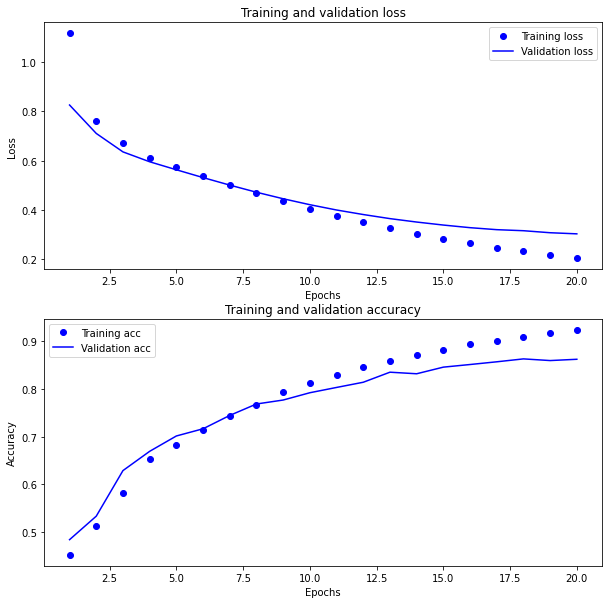

In [8]:
print('Show history')
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,10))

plt.subplot(211) # show loss history
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212) # show accuracy history
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()